Script to train a Support Vector Machine to classify sessions into low versus high neural stability based on several behavioural indicators

In [1]:
# 1. Import packages

from tkinter import filedialog
import numpy as np 
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
# 2. Choose directory and load data from each session
# These 1-D vectors contain either the total number or the average number of each variable per session

directory = filedialog.askdirectory()
print("Selected directory:", directory)
numberLicks = np.load (directory + "numberLicks.npy")
numberTrials = np.load (directory + "numberTrials.npy")
pausingTime = np.load (directory + "pausingTime.npy")
PCstab = np.load (directory + "PCstability.npy") 
preRewLicks = np.load (directory + "preRewardLicks.npy")
preRewSlope = np.load (directory + "preRewardSlope.npy")
licksC = np.load(directory + "roomCLicks.npy")
speedC = np.load(directory + "roomCspeed.npy")
speed = np.load(directory + "runningSpeed.npy")
postRewLicks1Sec = np.load (directory + "postRewardLicks1sec.npy")
postRewLicksHalfSec = np.load (directory + "postRewardLicks3sec.npy")
postRewLicksQuarterSec = np.load (directory + "postRewardLicks5sec.npy")

Selected directory: C:/Users/Sara/Documents/Analysis/Python analysis/fromMatlab/


PC stability 0.20 gives 0.64 accuracy with a std of 0.15
PC stability 0.30 gives 0.75 accuracy with a std of 0.17
PC stability 0.40 gives 0.75 accuracy with a std of 0.15
PC stability 0.50 gives 0.75 accuracy with a std of 0.15
PC stability 0.60 gives 0.76 accuracy with a std of 0.13
PC stability 0.70 gives 0.73 accuracy with a std of 0.10
PC stability 0.80 gives 0.70 accuracy with a std of 0.10


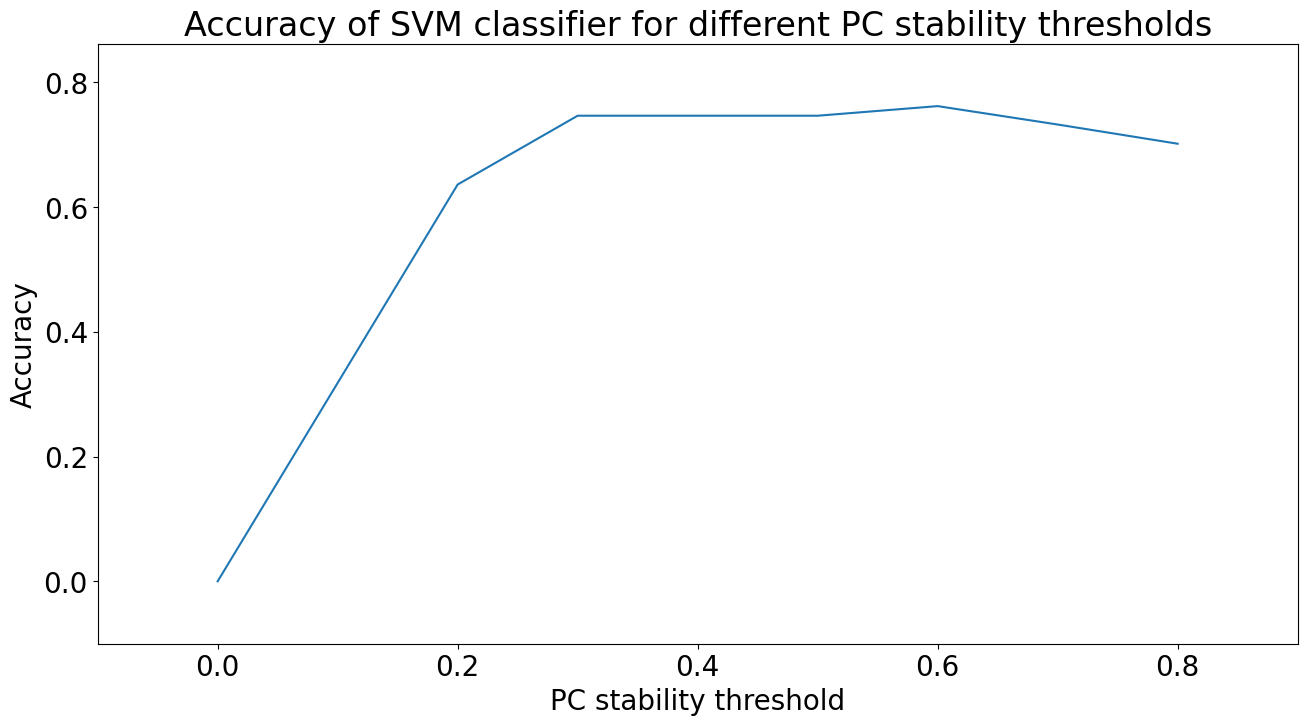

In [11]:
# 3. Train an SVM classifier testing different stability thresholds to find the cut-off point for optimal performance

# 3.1. Prepare data for the SVM classifier and initialize output variable
variables = np.column_stack((numberLicks, numberTrials, pausingTime, preRewLicks, preRewSlope, licksC, speedC, speed))
stabilities = np.arange(0.2,0.8,0.1)
features_names = ['numberLicks', 'numberTrials', 'pausingTime', 'preRewardLicks', 'preRewardSlope', 'licksRoomC', 'speedRoomC', 'speed']
results = np.ndarray((len(stabilities),2))

# 3.2. Iterate over all stability values 
for stab in stabilities: 
    # label sessions depending on whether their average stability score is above(1) or below(0) the designated stability threshold for this iteration
    stabilityLabels = np.zeros((PCstab.shape[0],1)) 
    stabilityLabels[PCstab >= stab] = 1
    
    # train classifier using cross validation
    clf = svm.SVC()
    scores = cross_val_score(clf, variables, stabilityLabels.ravel(), cv=5)
    results = np.vstack([results, np.array([[stab, scores.mean()]])]) # store the performance and stability threshold used
    print("PC stability %0.2f gives %0.2f accuracy with a std of %0.2f" % (stab, scores.mean(), scores.std()))

if 'resultsData' in locals():
    del resultsData
resultsData = pd.DataFrame(results, columns = ["Stability threshold", "Accuracy"])   # convert the numpy array into a pandas dataframe

# Plot a lineplot displaying the accuracy of the classifier at each stability threshold and save figure
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.plot(resultsData["Stability threshold"].values,  resultsData["Accuracy"].values)
a1.set_title('Accuracy of SVM classifier for different PC stability thresholds')
a1.set_ylim(np.min(resultsData["Accuracy"].values)-0.1, np.max(resultsData["Accuracy"].values)+0.1)
a1.set_xlim(np.min(resultsData["Stability threshold"].values)-0.1, np.max(resultsData["Stability threshold"].values)+0.1)
a1.set_xlabel('PC stability threshold')
a1.set_ylabel('Accuracy')
plt.rcParams.update({'font.size': 20})
fig.set_size_inches(12, 6) # set figure's size manually 

directory_fig = filedialog.askdirectory()
print("Selected directory for figure:", directory_fig)
plt.savefig(directory_fig + 'plot_SVMperformanceAcrossThresholds.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
# 4. After selecting the optimal stability threshold (in the case of my data the threshold selected is 0.5), increase SVM performance by hyperparameter tuning

# 4.1. Establish variables and specify stability threshold used
variables = np.column_stack((numberLicks, numberTrials, pausingTime, preRewLicks, preRewSlope, licksC, speedC, speed))
stabilities = np.arange(0.2,0.8,0.1)
features_names = ['numberLicks', 'numberTrials', 'pausingTime', 'preRewardLicks', 'preRewardSlope', 'licksRoomC', 'speedRoomC', 'speed']
stabilityLabels = np.zeros((PCstab.shape[0],1))
stab = 0.5 # threshold used will be 0.5, since that gave the best SVM performance
stabilityLabels[PCstab >= stab] = 1 

# 4.2. Preprocess variables
X_train, X_test, y_train, y_test = train_test_split(variables, stabilityLabels.ravel(), test_size = 0.30, random_state = 101) 
scaler = StandardScaler()
X_trainScaled = scaler.fit(X_train).transform(X_train)
X_testScaled = scaler.transform(X_test)

# 4.3. Determine hyperparameter values used for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  

# 4.4. Initialize classifier, perform grid search with crossvalidation and print the optimal hyperparameters for our dataset
clf = svm.SVC()
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)   
grid.fit(X_trainScaled, y_train)
print("The best hyperparameters are: ", grid.best_params_) 

# 4.5. Now use the best hyperparameters to predict the output variable, in this case sessions with low(0) or high(1) stability, and print accuracy
grid_predictions = grid.predict(X_testScaled) 
accuracy = accuracy_score(y_test, grid_predictions)
print("Accuracy:", accuracy)

    Stability threshold       Accuracy
0          0.000000e+00  2.121996e-314
1         4.243992e-314  4.243992e-314
2         6.365987e-314  8.487983e-314
3         8.487983e-314   6.358974e-01
4          7.461538e-01   7.461538e-01
5          7.461538e-01   7.615385e-01
6          7.320513e-01   7.012821e-01
7          2.000000e-01   6.358974e-01
8          3.000000e-01   7.461538e-01
9          4.000000e-01   7.461538e-01
10         5.000000e-01   7.461538e-01
11         6.000000e-01   7.615385e-01
12         7.000000e-01   7.320513e-01
13         8.000000e-01   7.012821e-01
